# **Stable Diffusion** 🎨

### Setup

In [ ]:
!nvidia-smi

Sat Oct 21 03:22:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


# Installing transformers scipy ftfy accelerate, diffusers

In [ ]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


# Stable Diffusion Pipeline
These are different models that we can try

* [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)
* [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
* [stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1). This version can produce images with a resolution of 768x768, while the others work at 512x512.

We want to ensure that every free Google Colab can run Stable Diffusion, hence we're loading the weights from the half-precision branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) and also tell `diffusers` to expect the weights in float16 precision by passing `torch_dtype=torch.float16`.


In [ ]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

model_id = "stabilityai/stable-diffusion-xl-base-1.0"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)


text_encoder/pytorch_model.fp16.safetensors not found


Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

Next, let's move the pipeline to GPU to have faster inference.

In [ ]:
pipe = pipe.to("cuda")

And we are ready to generate images:

  0%|          | 0/50 [00:00<?, ?it/s]

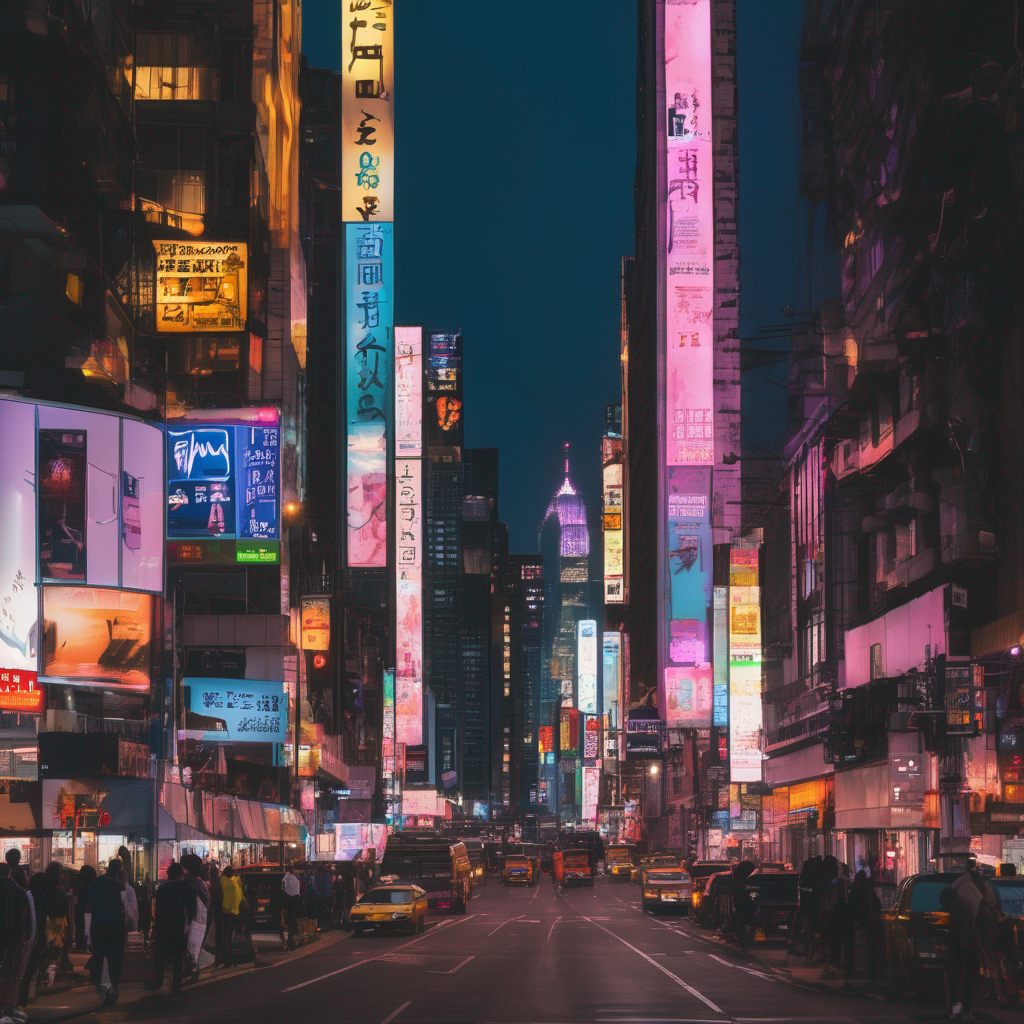

In [ ]:
prompt = "Photograph of a busy city street at dusk, taken from a low angle, with towering buildings and vibrant neon lights."
image = pipe(prompt).images[0]
image

Running the above cell multiple times will give you a different image every time. If you want deterministic output you can pass a random seed to the pipeline. Every time you use the same seed you'll have the same image result.

  0%|          | 0/50 [00:00<?, ?it/s]

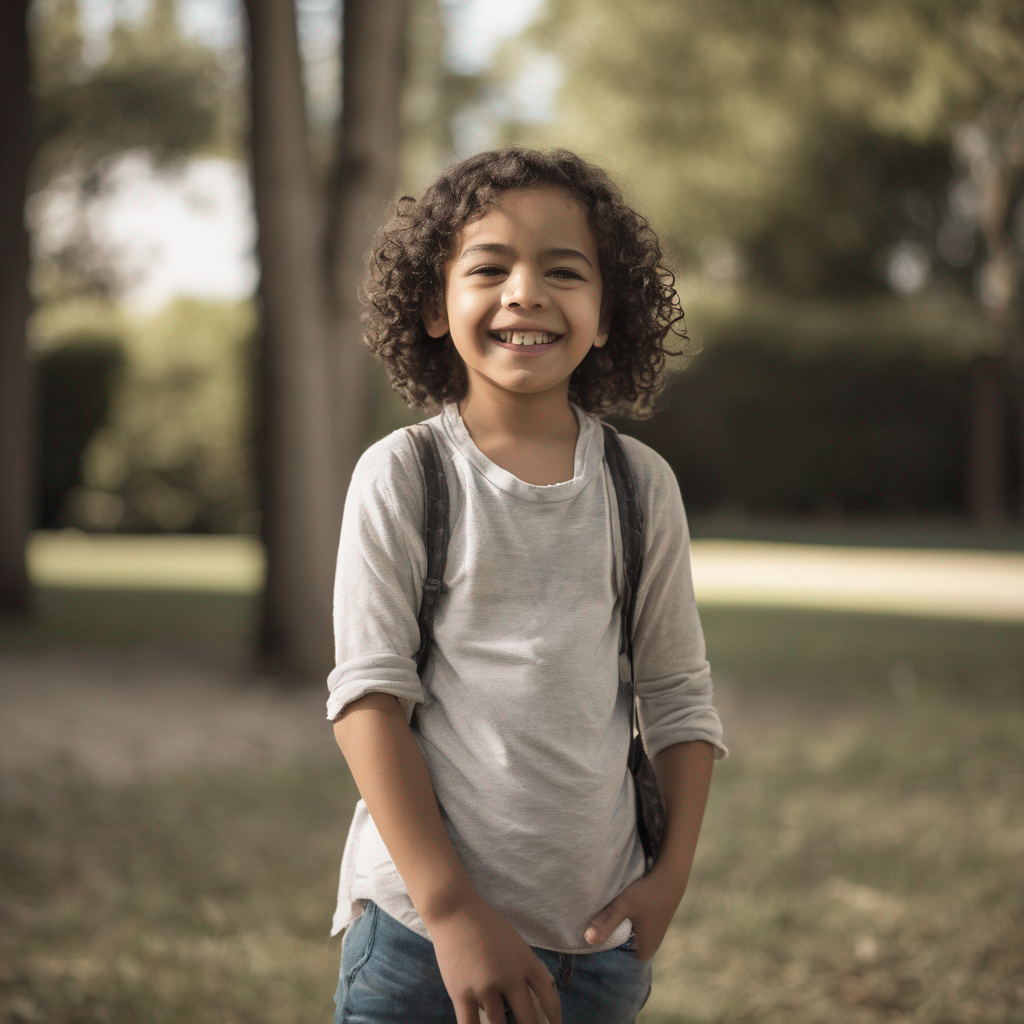

In [ ]:
import torch

prompt = "Portrait of a child playing in a park, using natural lighting and candid expressions"
generator = torch.Generator("cuda").manual_seed(1024)
image = pipe(prompt, generator=generator).images[0]

image

In [ ]:
import torch

generator = torch.Generator("cuda").manual_seed(1024)

image = pipe(prompt, num_inference_steps=15, generator=generator).images[0]

image



Let's first write a helper function to display a grid of images. Just run the following cell to create the `image_grid` function, or disclose the code if you are interested in how it's done.

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Now, we can generate a grid image once having run the pipeline with a list of 3 prompts.

In [ ]:
num_images = 3
prompt = ["Realistic painting of a quiet moment between a child and their pet, with an emphasis on expression and mood"] * num_images

images = pipe(prompt).images

grid = image_grid(images, rows=1, cols=3)
grid

And here's how to generate a grid of `n × m` images.

In [ ]:
num_cols = 3
num_rows = 4

prompt = ["Realistic painting of a solitary lighthouse silhouetted against the vibrant colors of a sunset"] * num_cols

all_images = []
for i in range(num_rows):
  images = pipe(prompt).images
  all_images.extend(images)

grid = image_grid(all_images, rows=num_rows, cols=num_cols)
grid

### Generate non-square images

Stable Diffusion produces images of `512 × 512` pixels by default. But it's very easy to override the default using the `height` and `width` arguments, so you can create rectangular images in portrait or landscape ratios.

These are some recommendations to choose good image sizes:
- Make sure `height` and `width` are both multiples of `8`.
- Going below 512 might result in lower quality images.
- Going over 512 in both directions will repeat image areas (global coherence is lost).
- The best way to create non-square images is to use `512` in one dimension, and a value larger than that in the other one.

In [ ]:
prompt = "Long-exposure photograph of a busy intersection at night, capturing the streaks of light from moving vehicles"

image = pipe(prompt, height=512, width=768).images[0]
image